# Gradient Bandit

In [269]:
import numpy as np
import gym
from gym import spaces
from gym.utils import seeding
import matplotlib.pyplot as plt
%matplotlib inline

In [271]:
class BanditEnv(gym.Env):
    """
    Bandit environment base to allow agents to interact with the class n-armed bandit
    in different variations
    p_dist:
        A list of probabilities of the likelihood that a particular bandit will pay out
    r_dist:
        A list of either rewards (if number) or means and standard deviations (if list)
        of the payout that bandit has
    """
    def __init__(self, p_dist, r_dist):
        if len(p_dist) != len(r_dist):
            raise ValueError("Probability and Reward distribution must be the same length")

        if min(p_dist) < 0 or max(p_dist) > 1:
            raise ValueError("All probabilities must be between 0 and 1")

        for reward in r_dist:
            if isinstance(reward, list) and reward[1] <= 0:
                raise ValueError("Standard deviation in rewards must all be greater than 0")

        self.p_dist = p_dist
        self.r_dist = r_dist

        self.n_bandits = len(p_dist)
        self.action_space = spaces.Discrete(self.n_bandits)
        self.observation_space = spaces.Discrete(1)

        self._seed()

    def _seed(self, seed=None):
        self.np_random, seed = seeding.np_random(seed)
        return [seed]

    def step(self, action):
        assert self.action_space.contains(action)

        reward = 0
        done = True

        if np.random.uniform() < self.p_dist[action]:
            if not isinstance(self.r_dist[action], list):
                reward = self.r_dist[action]
            else:
                reward = np.random.normal(self.r_dist[action][0], self.r_dist[action][1])

        return 0, reward, done, {}

    def _reset(self):
        return 0

    def _render(self, mode='human', close=False):
        pass

class BanditTenArmedGaussian(BanditEnv):
    """
    10 armed bandit mentioned on page 30 of Sutton and Barto's
    [Reinforcement Learning: An Introduction](https://www.dropbox.com/s/b3psxv2r0ccmf80/book2015oct.pdf?dl=0)
    Actions always pay out
    Mean of payout is pulled from a normal distribution (0, 1) (called q*(a))
    Actual reward is drawn from a normal distribution (q*(a), 1)
    """
    def __init__(self, bandits=10):
        p_dist = np.full(bandits, 1)
        r_dist = []

        for i in range(bandits):
            r_dist.append([np.random.normal(0, 1), 1])

        BanditEnv.__init__(self, p_dist=p_dist, r_dist=r_dist)

In [274]:
env = BanditTenArmedGaussian(bandits=4)
env.seed=(5)
env.action_space

Discrete(4)

done
H after: [-1.56995814 -1.38324824  0.34570209  2.6075043 ]
Softmax: [0.01347765 0.01624431 0.09153242 0.87874561]
env dist: [[0.22017105208076254, 1], [0.05274397941762539, 1], [0.4898721866714413, 1], [0.8177212592664066, 1]]


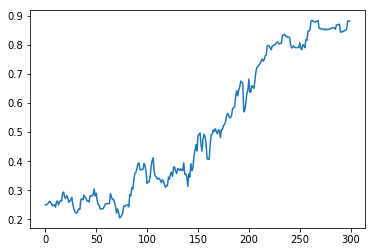

In [345]:
class Agent():
    def __init__(self, env):
        self.env = env
        self.alpha = 0.1
        self.actions = np.arange(self.env.action_space.n) # available actions
        # best action based for env
        self.best_action = np.argmax([reward for reward, probability in self.env.r_dist])  
        self.average_reward = 0
        self.H = np.zeros(4)
        self.best_action_percent = []
        
    def get_action(self):
        softmax = self.softmax()
        self.best_action_percent.append(softmax[self.best_action])
        return np.random.choice(self.actions, p=softmax)
        
    def softmax(self):
        top = np.exp(self.H)
        bottom = np.sum(top)
        softmax = top/bottom
        return softmax
    
        
    def run(self):
        for i in range(300):
            action = self.get_action()
            obs, reward, done, _ = self.env.step(action)

            count = i+1
            self.average_reward = self.average_reward + (reward - self.average_reward) / count
    
            onehot = np.zeros(4)
            onehot[action] = 1
#             self.average_reward = 0
            self.H = self.H + self.alpha * (reward - self.average_reward) * (onehot - self.softmax())
            
        print("done")
        print("H after:", self.H)
        print("Softmax:", self.softmax())
        print("env dist:", self.env.r_dist)
        plt.plot(self.best_action_percent)

agent = Agent(env)
agent.run()

In [206]:
# np.random.choice([0, 1, 2, 3], p=[0.5, 0, 0, 0.5])
# np.arange(4)
# np.arange(4)

array([0, 1, 2, 3])